# Clutering and classification analysis for the drug review data

The zipped data can be downloaded from https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip. It contains two datasets: drugComTest_raw.tsv, drugComTrain_raw.tsv. They are pre-seperated by the submitter. Detailed data description can be found at https://archive.ics.uci.edu/ml/datasets/Drug+Review+Dataset+%28Drugs.com%29. Basically, this dataset provides patient reviews on specific drugs along with related conditions. In this analysis, I mainly focus on the patients' reviews and cluster, classify based on the text information.

## 1. Import python tools

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from nltk import tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import matplotlib.pyplot as plt

## 2. Data cleaning

Datasets are read and concatenated into one because the first task is clustering and no need for eveluation. To reduce the running time of the script, the models are built on 5000 observations. (I tried for all observations, the sentiment analysis took **VERY** long) If has more powerful engine, one can use the whole dataset and do exactally the same for all the rest steps.

In [2]:
train=pd.read_csv('drugsComTrain_raw.tsv',sep='\t')
test=pd.read_csv('drugsComTest_raw.tsv',sep='\t')
#data=pd.concat([train,test])
data=pd.concat([train,test]).iloc[:5000,:]
data.head(12)

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37
5,155963,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2.0,"November 28, 2015",43
6,165907,Levonorgestrel,Emergency Contraception,"""He pulled out, but he cummed a bit in me. I t...",1.0,"March 7, 2017",5
7,102654,Aripiprazole,Bipolar Disorde,"""Abilify changed my life. There is hope. I was...",10.0,"March 14, 2015",32
8,74811,Keppra,Epilepsy,""" I Ve had nothing but problems with the Kepp...",1.0,"August 9, 2016",11
9,48928,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",8.0,"December 8, 2016",1


The data has seven features and five thousands observations. I first drop the meaningless column 'Unnamed: 0' and the missing occurs only at the feature 'condition'. 

In [3]:
data.columns.values
data=data.drop(['Unnamed: 0'],axis=1)
pd.isnull(data).sum()

drugName        0
condition      28
review          0
rating          0
date            0
usefulCount     0
dtype: int64

Then figure out there are 1103 categories in the 'durgName' and 374 in 'condition'.

In [4]:
def unique(series):
    x = np.array(list(series))
    return(np.unique(x))
drug=unique(data['drugName']); print(len(drug))
condition=unique(data['condition']); print(len(condition))


1103
374


### 2.1 Sentiment analysis

Write a function to calculate three sentiment scores for a given text: negative scores, neutral scores and positive scores. 

In [5]:
def ana_sentiment(text):
    sia = SIA()
    results = []
    text_s=tokenize.sent_tokenize(text)

    for s in text_s:
      pol_score = sia.polarity_scores(s)
      pol_score['headline'] = s
      results.append(pol_score)

    df = pd.DataFrame.from_records(results)
    sent_scores=list(df.mean(axis=0)) 
    return(sent_scores)

Based on above function, creat three features for the negative, neutral and positive scores of each review. Then drop meaningless features. Someone may ask why not retain drugName or condtion. The reason is: I want the customers' review play the main role in this clustering. Also, for the clustering, one need to define the distance for pairwise obsrevations. However, in this case, if we define the distance based on all the features and encode categorical variables, the dimension after encoding can be very large and may replace the role that sentiment scores plays in the clustering. In other words, those categorical variables mainly influent the distances and thus the clustering results. 

In [6]:
neg_score=[];neu_score=[];pos_score=[]
for ind, row in data.iterrows():
    s=ana_sentiment(row['review'])
    neg_score.append(s[1]); neu_score.append(s[2]); pos_score.append(s[3])

data_clean=data.copy()
data_clean['neg_score']=neg_score;
data_clean['neu_score']=neu_score;
data_clean['pos_score']=pos_score
data_clean=data_clean.drop(['drugName','condition','review','rating','date'],axis=1)
data_clean.head(10)

,usefulCount,neg_score,neu_score,pos_score
0,27,0.136000,0.864000,0.000000
1,192,0.020455,0.852727,0.126818
2,17,0.019111,0.903778,0.077111
3,10,0.008800,0.873400,0.117800
4,37,0.042182,0.791182,0.166727
5,43,0.136000,0.753000,0.110833
6,5,0.000000,1.000000,0.000000
7,32,0.094545,0.801364,0.104091
8,11,0.207000,0.677000,0.116000
9,1,0.162700,0.682300,0.155300


### 2.2 Normalization

Now the data has four features: *usefulCount*, *neg_score*, *neu_score*, *pos_score*. Since for the clustering, pariwise distances are sensitive, I normalized all the columns. 

In [7]:
min_max_scaler = preprocessing.MinMaxScaler()
df=pd.DataFrame(min_max_scaler.fit_transform(data_clean))
df.columns=data_clean.columns
df.head(10)

,usefulCount,neg_score,neu_score,pos_score
0,0.021652,0.166259,0.836342,0.000000
1,0.153970,0.025006,0.822777,0.152609
2,0.013633,0.023363,0.884209,0.092793
3,0.008019,0.010758,0.847653,0.141757
4,0.029671,0.051567,0.748715,0.200635
5,0.034483,0.166259,0.702768,0.133373
6,0.004010,0.000000,1.000000,0.000000
7,0.025662,0.115581,0.760967,0.125260
8,0.008821,0.253056,0.611312,0.139591
9,0.000802,0.198900,0.617690,0.186883


## 3. Clustering and visualization

Hierarchical clustering is implemented. It carefully calculate the Wald distances between pairs of observations so that the points which are cose to each other in the 4-dimensioned sample space will be clustered in the sam group. I am interested how the data will be clustered in negative, neutral and positive reviews, so the number of clusters is set as 3.

In [8]:
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
cluster.fit_predict(df)

array([1, 1, 1, ..., 2, 2, 1], dtype=int64)

Results of the hierarchical clustering is visualized on the 2-dimensioned plane with xlab as the negative score and ylab as the pisitive score. From the plot, the data are clustered clearly into three groups with visible boundries.

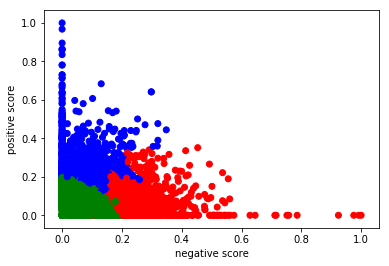

In [9]:
label_col=[]
for item in list(cluster.labels_):
    if item==0:
        label_col.append('blue')
    elif item==1:
        label_col.append('green')
    else:
        label_col.append('red')

plt.xlabel('negative score')
plt.ylabel('positive score')
plt.scatter(df.neg_score,df.pos_score, c=label_col)
plt.show()

The plot of all the data points with label 0 shows that in this cluster, positive scores are relatively higher than the negative score. Also, the positive scores themselves are not very small, say, larger than 0.1.

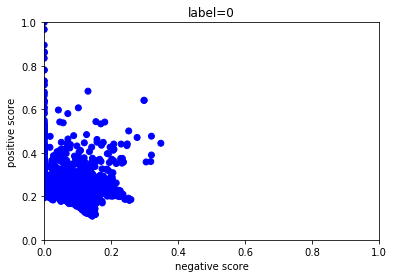

In [10]:
plt.xlim([0,1])
plt.ylim([0,1])
plt.title('label=0')
plt.xlabel('negative score')
plt.ylabel('positive score')
plt.scatter(df.neg_score[cluster.labels_==0],df.pos_score[cluster.labels_==0],
            c=['blue']*(cluster.labels_==0).sum())
plt.show()

For the plot of label 1, one can observe it's like a 1/4 circle. That is , both the negative and the positive scores are restricted.

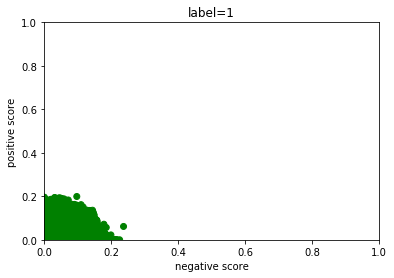

In [11]:
plt.xlim([0,1])
plt.ylim([0,1])
plt.title('label=1')
plt.xlabel('negative score')
plt.ylabel('positive score')
plt.scatter(df.neg_score[cluster.labels_==1],df.pos_score[cluster.labels_==1],
            c=['green']*(cluster.labels_==1).sum())
plt.show()

Finally, the plot of all the data points with label 2 shows that in this cluster, negative scores are relatively higher than the negative score. Similarly, the negative scores themselves are not very small.

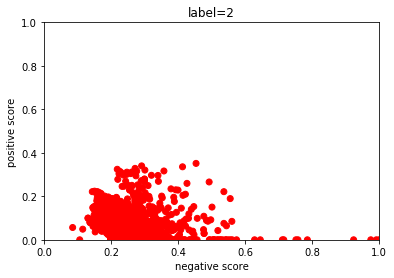

In [12]:
plt.xlim([0,1])
plt.ylim([0,1])
plt.title('label=2')
plt.xlabel('negative score')
plt.ylabel('positive score')
plt.scatter(df.neg_score[cluster.labels_==2],df.pos_score[cluster.labels_==2],
            c=['red']*(cluster.labels_==2).sum())
plt.show()

## 4. Classification

Based on observations from above plots, I assigned cluster 0 with class label 'positive', 1 with class label 'neutral' and 2 with 'negative'. Then seperate data randomly into training and testing datasets so that approximately 20% data points are in the test.

In [17]:
label=[]
for item in list(cluster.labels_):
    if item==0:
        label.append('positive')
    elif item==1:
        label.append('neutral')
    else:
        label.append('negative')
df['label']=label
df.head(5)

,usefulCount,neg_score,neu_score,pos_score,label
0,0.021652,0.166259,0.836342,0.000000,neutral
1,0.153970,0.025006,0.822777,0.152609,neutral
2,0.013633,0.023363,0.884209,0.092793,neutral
3,0.008019,0.010758,0.847653,0.141757,neutral
4,0.029671,0.051567,0.748715,0.200635,positive


In [ ]:
df_data=df.iloc[:,:-1]; df_target=df.label
X_train, X_test, y_train, y_test = train_test_split(df_data, df_target, test_size=0.2, random_state=123)

Random forest model is implemented because in this case it has less variance by using multiple trees. The hyper-parameters of the model is tuned by 7-fold cross validation and at the end choose: *max_depth* as 6, *max_features* as 3, *min_samples_leaf* as 3, *min_sample_split* as 8 and *n_estimators* as 300.  
**This chunk may run for more than 30 minutes**

In [14]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [3, 4, 5, 6],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [200, 300, 500]
}

rf = RandomForestClassifier()

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=7)
grid_search.fit(X_train, y_train)

In [16]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 6,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 500}

Finally eveluate the model with accuracy. The result shows that 97.3% test data are correctly classified.

In [15]:
best_grid = grid_search.best_estimator_
pred=best_grid.predict(X_test)
accuracy=sum(pred==y_test)/len(y_test)
print(accuracy)

0.973
